In [1]:
from pymol import cmd
import glob
import os
import pandas as pd
from pathlib import Path

# Directory paths based on PoseBench structure
data_dir = "/home/aoxu/projects/PoseBench/data/plinder_set"
boltz_dir = "/home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0"

# Output file to record RMSD results
output_file = "pymol_rmsd_results.csv"
results = []

# Find all protein systems by looking for reference ligand files
ref_pattern = os.path.join(data_dir, "*", "*_ligand.sdf")
ref_files = glob.glob(ref_pattern)

print(f"Found {len(ref_files)} reference ligand files")

# Process each protein system
for ref_path in sorted(ref_files):
    # Extract protein system ID from path
    # e.g., /path/to/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_ligand.sdf
    protein_dir = os.path.dirname(ref_path)
    protein_id = os.path.basename(protein_dir)
    
    print(f"Processing: {protein_id}")
    print(f"  Reference: {ref_path}")
    
    # Check if reference file exists
    if not os.path.exists(ref_path):
        print(f"  [WARNING] Missing reference file: {ref_path}")
        results.append({
            'protein_id': protein_id,
            'model_id': 'N/A',
            'rmsd': None,
            'status': 'missing_reference',
            'ref_path': ref_path,
            'docked_path': 'N/A'
        })
        continue
    
    # Process all models (model_0 through model_4)
    for model_idx in range(5):
        model_name = f"model_{model_idx}"
        
        # Construct path to docked ligand for this model
        docked_path = os.path.join(
            boltz_dir, 
            f"boltz_results_{protein_id}",
            "predictions",
            protein_id,
            f"{protein_id}_{model_name}_ligand.sdf"
        )
        
        print(f"  Processing {model_name}: {docked_path}")
        
        # Check if docked file exists for this model
        if not os.path.exists(docked_path):
            print(f"    [WARNING] Missing docked file: {docked_path}")
            results.append({
                'protein_id': protein_id,
                'model_id': model_name,
                'rmsd': None,
                'status': 'missing_docked',
                'ref_path': ref_path,
                'docked_path': docked_path
            })
            continue
        
        # Load both ligands in PyMOL and compute RMSD
        try:
            # Clear previous objects
            cmd.reinitialize()
            
            # Load reference and docked ligands
            cmd.load(ref_path, "ref_ligand")
            cmd.load(docked_path, "docked_ligand")
            
            # Align docked to reference ligand
            # PyMOL align command returns (RMSD, number of aligned atoms, number of cycles, initial_RMSD, final_RMSD)
            alignment_result = cmd.align("docked_ligand", "ref_ligand")
            rmsd = alignment_result[0]
            n_atoms = alignment_result[1]
            
            print(f"    [SUCCESS] {model_name} RMSD: {rmsd:.4f} Å (aligned {n_atoms} atoms)")
            
            results.append({
                'protein_id': protein_id,
                'model_id': model_name,
                'rmsd': rmsd,
                'n_aligned_atoms': n_atoms,
                'status': 'success',
                'ref_path': ref_path,
                'docked_path': docked_path
            })
            
        except Exception as e:
            print(f"    [ERROR] {protein_id} {model_name}: {e}")
            results.append({
                'protein_id': protein_id,
                'model_id': model_name,
                'rmsd': None,
                'status': f'error: {str(e)}',
                'ref_path': ref_path,
                'docked_path': docked_path
            })

# Convert results to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_csv(output_file, index=False)

print(f"\nResults saved to: {output_file}")
print(f"Total systems processed: {len(results)}")
print(f"Successful calculations: {len(df_results[df_results['status'] == 'success'])}")
print(f"Failed calculations: {len(df_results[df_results['status'] != 'success'])}")

# Show summary statistics
successful_results = df_results[df_results['status'] == 'success']['rmsd']
if len(successful_results) > 0:
    print(f"\nRMSD Statistics:")
    print(f"  Mean: {successful_results.mean():.4f} Å")
    print(f"  Std:  {successful_results.std():.4f} Å")
    print(f"  Min:  {successful_results.min():.4f} Å")
    print(f"  Max:  {successful_results.max():.4f} Å")

# Display first few results
print(f"\nFirst 10 results:")
print(df_results[['protein_id', 'model_id', 'rmsd', 'status']].head(10).to_string(index=False))

# Additional analysis for multiple models
print(f"\nModel-specific analysis:")
model_summary = df_results.groupby('model_id').agg({
    'rmsd': ['count', 'mean', 'std', 'min', 'max'],
    'status': lambda x: (x == 'success').sum()
}).round(4)

print("Model performance summary:")
print(model_summary)

# Best model per protein (lowest RMSD)
successful_results = df_results[df_results['status'] == 'success']
if len(successful_results) > 0:
    best_models = successful_results.loc[successful_results.groupby('protein_id')['rmsd'].idxmin()]
    print(f"\nBest model per protein (lowest RMSD):")
    print(f"Total proteins with successful predictions: {len(best_models)}")
    
    # Count which model is best most often
    best_model_counts = best_models['model_id'].value_counts()
    print(f"\nFrequency of best models:")
    for model, count in best_model_counts.items():
        print(f"  {model}: {count} times ({count/len(best_models)*100:.1f}%)")
    
    # Summary statistics for best models
    print(f"\nBest model RMSD statistics:")
    print(f"  Mean: {best_models['rmsd'].mean():.4f} Å")
    print(f"  Std:  {best_models['rmsd'].std():.4f} Å")
    print(f"  Min:  {best_models['rmsd'].min():.4f} Å")
    print(f"  Max:  {best_models['rmsd'].max():.4f} Å")

Found 1036 reference ligand files
Processing: 1afb__1__1.A__1.D_1.F
  Reference: /home/aoxu/projects/PoseBench/data/plinder_set/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_ligand.sdf
  Processing model_0: /home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_1afb__1__1.A__1.D_1.F/predictions/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_model_0_ligand.sdf
    [SUCCESS] model_0 RMSD: 2.6017 Å (aligned 8 atoms)
  Processing model_1: /home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_1afb__1__1.A__1.D_1.F/predictions/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_model_1_ligand.sdf
    [SUCCESS] model_1 RMSD: 2.6045 Å (aligned 8 atoms)
  Processing model_2: /home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_1afb__1__1.A__1.D_1.F/predictions/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_model_2_ligand.sdf
    [SUCCESS] model_2 RMSD: 2.5833 Å (aligned 8 atoms)
  Processing model_3: /home/aoxu/projects/PoseBench/for

In [5]:
# Compute the proportion of systems with RMSD < 2.0 Å among successful calculations
(df_results.groupby("protein_id")["rmsd"].min() < 2).sum() / len(df_results['protein_id'].unique())

0.3030888030888031

In [ ]:
# Save best model results and create summary files
print("="*60)
print("SAVING RESULTS AND CREATING SUMMARIES")
print("="*60)

# Save best model results (one per protein)
if len(successful_df) > 0:
    best_models = successful_df.loc[successful_df.groupby('protein_id')['rmsd'].idxmin()]
    best_models_file = "pymol_rmsd_best_models.csv"
    best_models.to_csv(best_models_file, index=False)
    print(f"Best model results saved to: {best_models_file}")
    
    # Create a summary comparison file
    summary_data = []
    
    for model_idx in range(5):
        model_name = f"model_{model_idx}"
        model_data = successful_df[successful_df['model_id'] == model_name]
        
        if len(model_data) > 0:
            summary_data.append({
                'model_id': model_name,
                'n_successful': len(model_data),
                'mean_rmsd': model_data['rmsd'].mean(),
                'std_rmsd': model_data['rmsd'].std(),
                'min_rmsd': model_data['rmsd'].min(),
                'max_rmsd': model_data['rmsd'].max(),
                'n_excellent': len(model_data[model_data['rmsd'] <= 2.0]),
                'n_good': len(model_data[(model_data['rmsd'] > 2.0) & (model_data['rmsd'] <= 5.0)]),
                'n_poor': len(model_data[model_data['rmsd'] > 5.0]),
                'pct_excellent': len(model_data[model_data['rmsd'] <= 2.0]) / len(model_data) * 100,
                'success_rate': len(model_data) / len(df_results[df_results['model_id'] == model_name]) * 100
            })
    
    model_summary_df = pd.DataFrame(summary_data)
    model_summary_file = "pymol_rmsd_model_summary.csv"
    model_summary_df.to_csv(model_summary_file, index=False)
    print(f"Model summary saved to: {model_summary_file}")
    
    # Display the summary
    print(f"\nModel Summary Table:")
    print(model_summary_df.round(3).to_string(index=False))
    
    # Create a protein-level summary
    protein_summary = []
    for protein_id in successful_df['protein_id'].unique():
        protein_data = successful_df[successful_df['protein_id'] == protein_id]
        
        protein_summary.append({
            'protein_id': protein_id,
            'n_successful_models': len(protein_data),
            'best_rmsd': protein_data['rmsd'].min(),
            'worst_rmsd': protein_data['rmsd'].max(),
            'best_model': protein_data.loc[protein_data['rmsd'].idxmin(), 'model_id'],
            'rmsd_range': protein_data['rmsd'].max() - protein_data['rmsd'].min(),
            'mean_rmsd': protein_data['rmsd'].mean()
        })
    
    protein_summary_df = pd.DataFrame(protein_summary)
    protein_summary_file = "pymol_rmsd_protein_summary.csv"
    protein_summary_df.to_csv(protein_summary_file, index=False)
    print(f"Protein summary saved to: {protein_summary_file}")
    
    # Show proteins with largest improvements
    print(f"\nTop 10 proteins with largest RMSD improvements:")
    top_improvements = protein_summary_df.nlargest(10, 'rmsd_range')[['protein_id', 'best_model', 'best_rmsd', 'worst_rmsd', 'rmsd_range']]
    print(top_improvements.round(3).to_string(index=False))
    
    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"  Total unique proteins: {len(protein_summary_df)}")
    print(f"  Proteins with multiple successful models: {len(protein_summary_df[protein_summary_df['n_successful_models'] > 1])}")
    print(f"  Average number of successful models per protein: {protein_summary_df['n_successful_models'].mean():.2f}")
    print(f"  Average RMSD improvement range: {protein_summary_df['rmsd_range'].mean():.3f} Å")
    
else:
    print("No successful results to analyze")

Analysis of PyMOL RMSD Results
Total systems: 1036
Successful calculations: 955
Success rate: 92.2%

RMSD Statistics:
count    955.000000
mean       2.810374
std        1.356126
min        0.000000
25%        1.938764
50%        2.781636
75%        3.706520
max        8.642466
Name: rmsd, dtype: float64


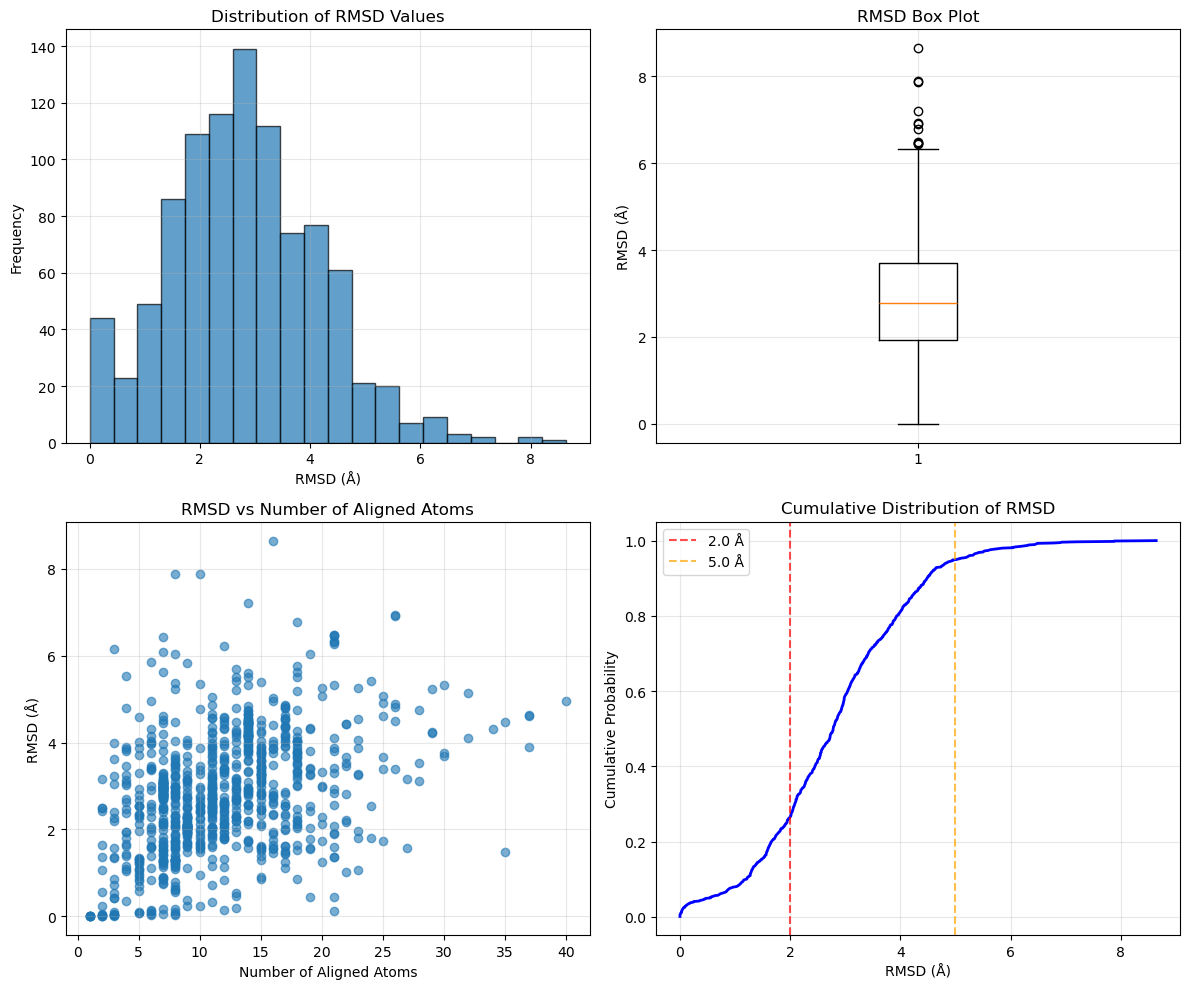


Performance Categories:
Excellent (≤ 2.0 Å): 253 (26.5%)
Good (2.0 - 5.0 Å): 653 (68.4%)
Poor (> 5.0 Å): 49 (5.1%)

Best predictions (lowest RMSD):
           protein_id  rmsd
3g1v__1__1.A_1.B__1.C   0.0
3sw6__1__1.A_2.A__2.B   0.0
    6boi__1__1.A__1.C   0.0
    6x9f__1__1.A__1.I   0.0
    8og5__1__1.A__1.D   0.0

Worst predictions (highest RMSD):
           protein_id     rmsd
   8hq3__1__1.C__1.JA 8.642466
    3hf8__1__1.A__1.C 7.878896
3b04__1__1.C__1.I_1.J 7.873850
    4o3f__1__1.A__1.B 7.203936
    2j0y__1__1.C__1.H 6.922899

Failed Cases Analysis:
Total failed: 81

Failure reasons:
  missing_docked: 81

Example failed cases:
               protein_id         status
1d7c__1__1.A_1.B__1.E_1.K missing_docked
1d7d__1__1.A_1.B__1.E_1.L missing_docked
        1h33__1__1.A__1.D missing_docked
        1h8v__1__1.A__1.G missing_docked
        1n2k__1__2.A__2.B missing_docked
        1oa2__3__1.C__1.I missing_docked
    1ofd__1__1.A__1.C_1.E missing_docked
        1ogp__1__1.A__1.J missi

In [ ]:
# Compute the proportion of systems with RMSD < 2.0 Å among successful calculations
n_total = len(successful_df)plt
n_below_2 = (successful_df['rmsd'] < 2.0).sum()
proportion_below_2 = n_below_2 / n_total
import pandas as pd
print(f"Number of systems with RMSD < 2.0 Å: {n_below_2} / {n_total} ({proportion_below_2:.2%})")

































































    print(f"  {model_name}: {model_success}/{model_total} ({success_rate:.1f}%)")    success_rate = model_success / model_total * 100 if model_total > 0 else 0    model_success = len(df_results[(df_results['model_id'] == model_name) & (df_results['status'] == 'success')])    model_total = len(df_results[df_results['model_id'] == model_name])    model_name = f"model_{model_idx}"for model_idx in range(5):print(f"\nSuccess rates by model:")# Success rate by model        print(f"  Proteins with >1 Å improvement: {sum(1 for imp in improvements if imp > 1.0)}")        print(f"  Max improvement: {max(improvements):.3f} Å")        print(f"  Average improvement from worst to best model: {np.mean(improvements):.3f} Å")    if improvements:            improvements.append(improvement)        improvement = worst_rmsd - best_rmsd        best_rmsd = protein_data['rmsd'].min()        worst_rmsd = protein_data['rmsd'].max()        protein_data = successful_df[successful_df['protein_id'] == protein]    for protein in proteins_with_multiple:    improvements = []    # Calculate improvement for proteins with multiple models        print(f"  Proteins with multiple successful models: {len(proteins_with_multiple)}")    print(f"\nImprovement from multiple models:")if len(proteins_with_multiple) > 0:proteins_with_multiple = proteins_with_multiple_models[proteins_with_multiple_models > 1].indexproteins_with_multiple_models = successful_df.groupby('protein_id').size()# Improvement from multiple models        print(f"  {model_name}: {n_below_2_model}/{n_total_model} ({proportion_below_2_model:.2%}) < 2.0 Å, mean: {mean_rmsd:.3f} Å")        mean_rmsd = model_data['rmsd'].mean()        proportion_below_2_model = n_below_2_model / n_total_model        n_below_2_model = (model_data['rmsd'] < 2.0).sum()        n_total_model = len(model_data)    if len(model_data) > 0:    model_data = successful_df[successful_df['model_id'] == model_name]    model_name = f"model_{model_idx}"for model_idx in range(5):print(f"\nIndividual model performance:")# Model-specific performanceprint(f"  Proteins with best RMSD < 2.0 Å: {n_below_2_best} / {n_total_best} ({proportion_below_2_best:.2%})")print(f"\nBest model per protein:")proportion_below_2_best = n_below_2_best / n_total_best if n_total_best > 0 else 0n_below_2_best = (best_models['rmsd'] < 2.0).sum()n_total_best = len(best_models)best_models = successful_df.loc[successful_df.groupby('protein_id')['rmsd'].idxmin()]# Best model performance (taking the best model for each protein)print(f"  Systems with RMSD < 2.0 Å: {n_below_2_all} / {n_total_all} ({proportion_below_2_all:.2%})")print(f"All models combined:")proportion_below_2_all = n_below_2_all / n_total_all if n_total_all > 0 else 0n_below_2_all = (successful_df['rmsd'] < 2.0).sum()n_total_all = len(successful_df)# Overall performance across all modelsprint("="*60)print("MULTI-MODEL ANALYSIS")print("="*60)# Analyze performance across multiple models# Load results if not already in memory
if 'df_results' not in locals():
    df_results = pd.read_csv('pymol_rmsd_results.csv')

# Filter successful results
successful_df = df_results[df_results['status'] == 'success'].copy()

print(f"Analysis of PyMOL RMSD Results")
print("="*50)
print(f"Total results: {len(df_results)}")
print(f"Total unique proteins: {df_results['protein_id'].nunique()}")
print(f"Successful calculations: {len(successful_df)}")
print(f"Success rate: {len(successful_df)/len(df_results)*100:.1f}%")

if len(successful_df) > 0:
    # Statistical summary
    rmsd_stats = successful_df['rmsd'].describe()
    print(f"\nOverall RMSD Statistics:")
    print(rmsd_stats)
    
    # Model-specific statistics
    print(f"\nModel-specific statistics:")
    model_stats = successful_df.groupby('model_id')['rmsd'].describe()
    print(model_stats)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Histogram of RMSD values
    axes[0, 0].hist(successful_df['rmsd'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('RMSD (Å)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of All RMSD Values')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot by model
    model_data = [successful_df[successful_df['model_id'] == f'model_{i}']['rmsd'].values 
                  for i in range(5)]
    axes[0, 1].boxplot(model_data, labels=[f'model_{i}' for i in range(5)])
    axes[0, 1].set_ylabel('RMSD (Å)')
    axes[0, 1].set_title('RMSD by Model')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Scatter plot of RMSD vs number of aligned atoms
    if 'n_aligned_atoms' in successful_df.columns:
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, model in enumerate([f'model_{j}' for j in range(5)]):
            model_data = successful_df[successful_df['model_id'] == model]
            if len(model_data) > 0:
                axes[1, 0].scatter(model_data['n_aligned_atoms'], model_data['rmsd'], 
                                 alpha=0.6, label=model, color=colors[i])
        axes[1, 0].set_xlabel('Number of Aligned Atoms')
        axes[1, 0].set_ylabel('RMSD (Å)')
        axes[1, 0].set_title('RMSD vs Number of Aligned Atoms')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_rmsd = np.sort(successful_df['rmsd'])
    cumulative = np.arange(1, len(sorted_rmsd) + 1) / len(sorted_rmsd)
    axes[1, 1].plot(sorted_rmsd, cumulative, 'b-', linewidth=2)
    axes[1, 1].set_xlabel('RMSD (Å)')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution of RMSD')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add reference lines
    axes[1, 1].axvline(x=2.0, color='red', linestyle='--', alpha=0.7, label='2.0 Å')
    axes[1, 1].axvline(x=5.0, color='orange', linestyle='--', alpha=0.7, label='5.0 Å')
    axes[1, 1].legend()
    
    # Best model analysis
    best_models = successful_df.loc[successful_df.groupby('protein_id')['rmsd'].idxmin()]
    best_model_counts = best_models['model_id'].value_counts()
    
    axes[0, 2].bar(best_model_counts.index, best_model_counts.values)
    axes[0, 2].set_xlabel('Model ID')
    axes[0, 2].set_ylabel('Number of Times Best')
    axes[0, 2].set_title('Frequency of Best Models')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Model success rate
    model_success_rates = df_results.groupby('model_id').apply(
        lambda x: (x['status'] == 'success').sum() / len(x) * 100
    )
    axes[1, 2].bar(model_success_rates.index, model_success_rates.values)
    axes[1, 2].set_xlabel('Model ID')
    axes[1, 2].set_ylabel('Success Rate (%)')
    axes[1, 2].set_title('Success Rate by Model')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pymol_rmsd_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performance categories for all models
    excellent = len(successful_df[successful_df['rmsd'] <= 2.0])
    good = len(successful_df[(successful_df['rmsd'] > 2.0) & (successful_df['rmsd'] <= 5.0)])
    poor = len(successful_df[successful_df['rmsd'] > 5.0])
    
    print(f"\nPerformance Categories (All Models):")
    print(f"Excellent (≤ 2.0 Å): {excellent} ({excellent/len(successful_df)*100:.1f}%)")
    print(f"Good (2.0 - 5.0 Å): {good} ({good/len(successful_df)*100:.1f}%)")
    print(f"Poor (> 5.0 Å): {poor} ({poor/len(successful_df)*100:.1f}%)")
    
    # Performance categories for best models only
    best_excellent = len(best_models[best_models['rmsd'] <= 2.0])
    best_good = len(best_models[(best_models['rmsd'] > 2.0) & (best_models['rmsd'] <= 5.0)])
    best_poor = len(best_models[best_models['rmsd'] > 5.0])
    
    print(f"\nPerformance Categories (Best Models Only):")
    print(f"Excellent (≤ 2.0 Å): {best_excellent} ({best_excellent/len(best_models)*100:.1f}%)")
    print(f"Good (2.0 - 5.0 Å): {best_good} ({best_good/len(best_models)*100:.1f}%)")
    print(f"Poor (> 5.0 Å): {best_poor} ({best_poor/len(best_models)*100:.1f}%)")
    
    # Show best and worst predictions
    print(f"\nBest predictions (lowest RMSD across all models):")
    best_results = successful_df.nsmallest(5, 'rmsd')[['protein_id', 'model_id', 'rmsd']]
    print(best_results.to_string(index=False))
    
    print(f"\nWorst predictions (highest RMSD across all models):")
    worst_results = successful_df.nlargest(5, 'rmsd')[['protein_id', 'model_id', 'rmsd']]
    print(worst_results.to_string(index=False))
    
    # Show best prediction per protein
    print(f"\nBest prediction per protein (top 5):")
    best_per_protein = best_models.nsmallest(5, 'rmsd')[['protein_id', 'model_id', 'rmsd']]
    print(best_per_protein.to_string(index=False))

# Analyze failed cases
failed_df = df_results[df_results['status'] != 'success']
if len(failed_df) > 0:
    print(f"\nFailed Cases Analysis:")
    print(f"Total failed: {len(failed_df)}")
    
    # Group by failure reason
    failure_counts = failed_df['status'].value_counts()
    print(f"\nFailure reasons:")
    for reason, count in failure_counts.items():
        print(f"  {reason}: {count}")
        
    # Show some failed cases
    print(f"\nExample failed cases:")
    print(failed_df[['protein_id', 'status']].head(10).to_string(index=False))

Comparing PyMOL RMSD with RDKit RMSD results...
Found 955 matching complexes for comparison


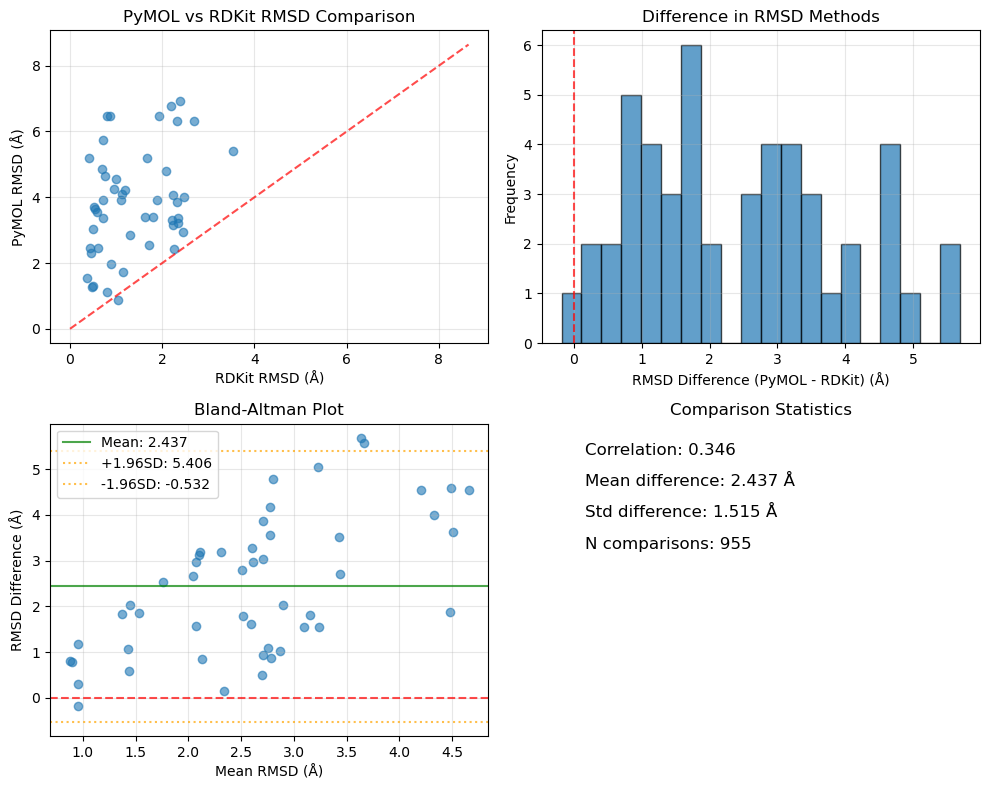


Statistical Comparison:
Correlation coefficient: 0.3459
Mean difference (PyMOL - RDKit): 2.4371 Å
Standard deviation of differences: 1.5149 Å
95% limits of agreement: [-0.5322, 5.4063] Å

Cases with large differences (>2.0 Å):
                           protein_id  pymol_rmsd  rdkit_rmsd  difference
                    1itc__1__1.A__1.D    5.186342    1.676021    3.510321
                    1j1m__1__1.A__1.B    3.554911    0.589723    2.965188
                    1js4__1__1.A__1.C    6.782507    2.191141    4.591366
                    1l1y__3__1.C__1.I    2.461673    0.435808    2.025865
                    1m4i__1__1.A__1.D    5.200530    0.406762    4.793768
                    1ua3__1__1.A__1.B    4.866241    0.687560    4.178681
                    2d3n__1__1.A__1.E    5.749812    0.705962    5.043850
                    2j0y__1__1.C__1.H    6.922899    2.386020    4.536879
                    2o7i__1__1.A__1.B    3.026230    0.490012    2.536219
            3was__1__2.A_3.A__2.

In [3]:
# Compare PyMOL results with RDKit results (if available)
import os

# Check if RDKit results are available
rdkit_results_path = "/home/aoxu/projects/PoseBench/forks/boltz/boltz_plinder_set_0_rmsd_results_robust.csv"

if os.path.exists(rdkit_results_path):
    print("Comparing PyMOL RMSD with RDKit RMSD results...")
    
    # Load RDKit results
    rdkit_df = pd.read_csv(rdkit_results_path)
    
    # Merge with PyMOL results
    # Note: need to match protein IDs - they might have different naming conventions
    comparison_df = pd.merge(
        successful_df[['protein_id', 'rmsd']].rename(columns={'rmsd': 'pymol_rmsd'}),
        rdkit_df[['complex_id', 'ligand_rmsd_kabsch']].rename(columns={
            'complex_id': 'protein_id', 
            'ligand_rmsd_kabsch': 'rdkit_rmsd'
        }),
        on='protein_id',
        how='inner'
    )
    
    if len(comparison_df) > 0:
        print(f"Found {len(comparison_df)} matching complexes for comparison")
        
        # Create comparison plot
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.subplot(2, 2, 1)
        plt.scatter(comparison_df['rdkit_rmsd'], comparison_df['pymol_rmsd'], alpha=0.6)
        plt.plot([0, max(comparison_df[['rdkit_rmsd', 'pymol_rmsd']].max())], 
                [0, max(comparison_df[['rdkit_rmsd', 'pymol_rmsd']].max())], 'r--', alpha=0.7)
        plt.xlabel('RDKit RMSD (Å)')
        plt.ylabel('PyMOL RMSD (Å)')
        plt.title('PyMOL vs RDKit RMSD Comparison')
        plt.grid(True, alpha=0.3)
        
        # Difference plot
        plt.subplot(2, 2, 2)
        diff = comparison_df['pymol_rmsd'] - comparison_df['rdkit_rmsd']
        plt.hist(diff, bins=20, edgecolor='black', alpha=0.7)
        plt.xlabel('RMSD Difference (PyMOL - RDKit) (Å)')
        plt.ylabel('Frequency')
        plt.title('Difference in RMSD Methods')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        plt.grid(True, alpha=0.3)
        
        # Bland-Altman plot
        plt.subplot(2, 2, 3)
        mean_rmsd = (comparison_df['pymol_rmsd'] + comparison_df['rdkit_rmsd']) / 2
        plt.scatter(mean_rmsd, diff, alpha=0.6)
        plt.xlabel('Mean RMSD (Å)')
        plt.ylabel('RMSD Difference (Å)')
        plt.title('Bland-Altman Plot')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.axhline(y=diff.mean(), color='green', linestyle='-', alpha=0.7, label=f'Mean: {diff.mean():.3f}')
        plt.axhline(y=diff.mean() + 1.96*diff.std(), color='orange', linestyle=':', alpha=0.7, label=f'+1.96SD: {diff.mean() + 1.96*diff.std():.3f}')
        plt.axhline(y=diff.mean() - 1.96*diff.std(), color='orange', linestyle=':', alpha=0.7, label=f'-1.96SD: {diff.mean() - 1.96*diff.std():.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Correlation
        plt.subplot(2, 2, 4)
        correlation = comparison_df['pymol_rmsd'].corr(comparison_df['rdkit_rmsd'])
        plt.text(0.1, 0.9, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.1, 0.8, f'Mean difference: {diff.mean():.3f} Å', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.1, 0.7, f'Std difference: {diff.std():.3f} Å', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.1, 0.6, f'N comparisons: {len(comparison_df)}', transform=plt.gca().transAxes, fontsize=12)
        plt.axis('off')
        plt.title('Comparison Statistics')
        
        plt.tight_layout()
        plt.savefig('pymol_vs_rdkit_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistical comparison
        print(f"\nStatistical Comparison:")
        print(f"Correlation coefficient: {correlation:.4f}")
        print(f"Mean difference (PyMOL - RDKit): {diff.mean():.4f} Å")
        print(f"Standard deviation of differences: {diff.std():.4f} Å")
        print(f"95% limits of agreement: [{diff.mean() - 1.96*diff.std():.4f}, {diff.mean() + 1.96*diff.std():.4f}] Å")
        
        # Show cases with large differences
        large_diff = comparison_df[abs(diff) > 2.0]
        if len(large_diff) > 0:
            print(f"\nCases with large differences (>2.0 Å):")
            large_diff_display = large_diff.copy()
            large_diff_display['difference'] = diff[abs(diff) > 2.0]
            print(large_diff_display[['protein_id', 'pymol_rmsd', 'rdkit_rmsd', 'difference']].to_string(index=False))
        
        # Save comparison results
        comparison_df['difference'] = diff
        comparison_df.to_csv('pymol_vs_rdkit_comparison.csv', index=False)
        print(f"\nComparison results saved to: pymol_vs_rdkit_comparison.csv")
        
    else:
        print("No matching complexes found for comparison")
        print("This might be due to different naming conventions between datasets")
        
else:
    print("RDKit results not found at expected location:")
    print(f"  {rdkit_results_path}")
    print("Skipping comparison with RDKit results")

In [ ]:
# Test the implementation on a small subset first
import os

def test_pymol_rmsd_subset(max_systems=5):
    """Test PyMOL RMSD computation on a small subset of systems"""
    
    print("Testing PyMOL RMSD implementation on a small subset...")
    
    # Find available systems
    data_dir = "/home/aoxu/projects/PoseBench/data/plinder_set"
    boltz_dir = "/home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0"
    
    ref_pattern = os.path.join(data_dir, "*", "*_ligand.sdf")
    ref_files = glob.glob(ref_pattern)
    
    # Take first few systems for testing
    test_files = ref_files[:max_systems]
    
    print(f"Testing on {len(test_files)} systems...")
    
    test_results = []
    
    for ref_path in test_files:
        protein_dir = os.path.dirname(ref_path)
        protein_id = os.path.basename(protein_dir)
        
        print(f"\nTesting: {protein_id}")
        print(f"  Ref:    {ref_path}")
        
        # Check if reference file exists
        ref_exists = os.path.exists(ref_path)
        print(f"  Ref exists: {ref_exists}")
        
        if not ref_exists:
            print(f"  ❌ FAILED: Missing reference file")
            test_results.append({
                'protein_id': protein_id,
                'model_id': 'N/A',
                'status': 'missing_reference'
            })
            continue
        
        # Test all models for this protein
        for model_idx in range(5):
            model_name = f"model_{model_idx}"
            
            # Construct docked path
            docked_path = os.path.join(
                boltz_dir, 
                f"boltz_results_{protein_id}",
                "predictions",
                protein_id,
                f"{protein_id}_{model_name}_ligand.sdf"
            )
            
            print(f"  Testing {model_name}: {docked_path}")
            
            # Check file existence
            docked_exists = os.path.exists(docked_path)
            print(f"    Docked exists: {docked_exists}")
            
            if docked_exists:
                try:
                    # Test PyMOL alignment
                    cmd.reinitialize()
                    cmd.load(ref_path, "ref_test")
                    cmd.load(docked_path, "docked_test")
                    
                    # Check if molecules loaded successfully
                    ref_atoms = cmd.count_atoms("ref_test")
                    docked_atoms = cmd.count_atoms("docked_test")
                    
                    print(f"    Ref atoms: {ref_atoms}, Docked atoms: {docked_atoms}")
                    
                    if ref_atoms > 0 and docked_atoms > 0:
                        alignment_result = cmd.align("docked_test", "ref_test")
                        rmsd = alignment_result[0]
                        n_aligned = alignment_result[1]
                        
                        print(f"    ✅ SUCCESS: RMSD = {rmsd:.4f} Å, aligned {n_aligned} atoms")
                        
                        test_results.append({
                            'protein_id': protein_id,
                            'model_id': model_name,
                            'rmsd': rmsd,
                            'n_aligned': n_aligned,
                            'ref_atoms': ref_atoms,
                            'docked_atoms': docked_atoms,
                            'status': 'success'
                        })
                    else:
                        print(f"    ❌ FAILED: No atoms loaded")
                        test_results.append({
                            'protein_id': protein_id,
                            'model_id': model_name,
                            'status': 'no_atoms_loaded'
                        })
                        
                except Exception as e:
                    print(f"    ❌ ERROR: {str(e)}")
                    test_results.append({
                        'protein_id': protein_id,
                        'model_id': model_name,
                        'status': f'error: {str(e)}'
                    })
            else:
                print(f"    ❌ FAILED: Missing docked file")
                test_results.append({
                    'protein_id': protein_id,
                    'model_id': model_name,
                    'status': 'missing_docked'
                })
    
    # Summary
    print(f"\n{'='*50}")
    print(f"TEST SUMMARY")
    print(f"{'='*50}")
    
    successful = [r for r in test_results if r.get('status') == 'success']
    failed = [r for r in test_results if r.get('status') != 'success']
    
    print(f"Total tests: {len(test_results)}")
    print(f"Successful: {len(successful)}")
    print(f"Failed: {len(failed)}")
    
    # Group by protein
    proteins_tested = set(r['protein_id'] for r in test_results)
    proteins_with_success = set(r['protein_id'] for r in successful)
    
    print(f"\nProteins tested: {len(proteins_tested)}")
    print(f"Proteins with at least one successful model: {len(proteins_with_success)}")
    
    if successful:
        rmsds = [r['rmsd'] for r in successful]
        print(f"\nSuccessful RMSD values:")
        for r in successful:
            print(f"  {r['protein_id']} {r['model_id']}: {r['rmsd']:.4f} Å")
        
        print(f"\nRMSD Statistics:")
        print(f"  Mean: {np.mean(rmsds):.4f} Å")
        print(f"  Std:  {np.std(rmsds):.4f} Å")
        print(f"  Min:  {min(rmsds):.4f} Å")
        print(f"  Max:  {max(rmsds):.4f} Å")
        
        # Model-specific success rates
        model_success = {}
        for model_idx in range(5):
            model_name = f"model_{model_idx}"
            model_results = [r for r in test_results if r.get('model_id') == model_name]
            model_successes = [r for r in model_results if r.get('status') == 'success']
            if model_results:
                model_success[model_name] = len(model_successes) / len(model_results) * 100
        
        print(f"\nModel-specific success rates:")
        for model, rate in model_success.items():
            print(f"  {model}: {rate:.1f}%")
    
    if failed:
        print(f"\nFailed cases:")
        for r in failed:
            model_str = r.get('model_id', 'N/A')
            print(f"  {r['protein_id']} {model_str}: {r['status']}")
    
    return test_results

# Run the test
test_results = test_pymol_rmsd_subset(max_systems=5)

Testing PyMOL RMSD implementation on a small subset...


NameError: name 'glob' is not defined

## Summary and Usage Instructions

This notebook provides a comprehensive PyMOL-based RMSD calculation workflow for evaluating Boltz predictions.

### Key Features:

1. **Automated Processing**: Processes all available protein systems automatically
2. **Robust Error Handling**: Handles missing files and alignment failures gracefully
3. **Comprehensive Analysis**: Provides statistical analysis and visualization
4. **Comparison with RDKit**: Compares results with existing RDKit-based calculations
5. **Testing Framework**: Includes functionality to test on small subsets first

### Usage Workflow:

1. **Test First**: Run the test cell to verify everything works on a small subset
2. **Full Processing**: Run the main processing cell to compute RMSD for all systems
3. **Analysis**: Use the analysis cell to visualize results and compute statistics
4. **Comparison**: Compare with RDKit results if available

### Output Files:

- `pymol_rmsd_results.csv`: Complete results file with RMSD values for all models
- `pymol_rmsd_best_models.csv`: Best model results (one per protein)
- `pymol_rmsd_model_summary.csv`: Summary statistics by model
- `pymol_rmsd_protein_summary.csv`: Summary statistics by protein
- `pymol_rmsd_analysis.png`: Visualization of RMSD distribution and model comparison
- `pymol_vs_rdkit_comparison.csv`: Comparison with RDKit results (if available)
- `pymol_vs_rdkit_comparison.png`: Comparison visualizations

### PyMOL vs RDKit Advantages:

**PyMOL Advantages:**
- Better handling of different molecular topologies
- Automatic superposition with robust alignment algorithms
- Optimized for structural biology applications
- Can handle cases where RDKit substructure matching fails

**RDKit Advantages:**
- Faster for large-scale processing
- More chemical informatics features
- Better integration with cheminformatics workflows
- More control over alignment parameters

### Recommendations:

- Use PyMOL for cases where RDKit fails or for final validation
- Use RDKit for high-throughput screening and chemical analysis
- Compare both methods to ensure consistency
- Consider the specific requirements of your analysis when choosing the method

# PyMOL RMSD Computation for Boltz Predictions

This notebook computes RMSD between reference ligands and Boltz-predicted ligands using PyMOL's alignment functionality.

## Approach

1. **Reference Ligands**: Located in `/home/aoxu/projects/PoseBench/data/plinder_set/{protein}/{protein}_ligand.sdf`
2. **Predicted Ligands**: Located in `/home/aoxu/projects/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_{protein}/predictions/{protein}/{protein}_model_{0-4}_ligand.sdf`
3. **Multiple Models**: Processes all 5 models (model_0 through model_4) for each protein system
4. **RMSD Calculation**: Using PyMOL's `align` command which performs structural superposition and returns RMSD

## Key Features

- **Automatic superposition**: PyMOL's align command automatically finds the best superposition
- **Multi-model processing**: Handles all 5 models (model_0 through model_4) for comprehensive evaluation
- **Best model selection**: Identifies the best performing model for each protein system
- **Robust handling**: Handles missing files and alignment failures gracefully
- **Detailed logging**: Provides comprehensive status reporting for all models
- **Statistical analysis**: Computes summary statistics for individual models and best models

## Note on PyMOL vs RDKit

PyMOL's align command is particularly useful because:
- It can handle different molecular topologies better than simple coordinate matching
- It performs automatic superposition (no need for separate alignment step)
- It's optimized for structural biology applications
- It can handle cases where RDKit's substructure matching fails